# 프로젝트 전처리

## import 

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

## 엑셀파일 데이터와 이미지 데이터 merge

In [2]:
df = pd.read_excel("./99/BA_Total_20200703.xlsx") # 저장 장소와 파일이름 정리
df.head()

,원본 Folder,원본 No.,filename,성별,검사 시 나이,신장,체중,BMI,BA,thres
0,BA(F-3yr)19명,1,original_001.jpg,2,3.0,88.9,11.3,14.3,3.3,60
1,BA(F-3yr)19명,2,original_002.jpg,2,3.0,95.9,13.5,14.7,1.8,53
2,BA(F-3yr)19명,3,original_003.jpg,2,3.0,88.2,13.0,16.8,2.4,36
3,BA(F-3yr)19명,4,original_004.jpg,2,3.2,88.7,12.9,16.4,2.3,30
4,BA(F-3yr)19명,5,original_005.jpg,2,3.3,90.8,14.0,17.0,4.0,35


In [3]:
filenames = df.loc[:,"filename"]
fixel_df = pd.DataFrame(columns = ["filename", "height", "width", "channel"])
for i, filename in filenames.iteritems():
    img = cv2.imread("./00/"+filename)
    height, width, channel = img.shape
    # 픽셀 리스트를 한 줄로 정리
#     fixel_list = [str(data) for data in img.flatten().tolist()]
#     fixel = " ".join(fixel_list)
    fixel_df.loc[i] = [filename, height, width, channel]

In [4]:
df = df.merge(fixel_df)

In [5]:
df.to_csv("./99/BA_Total_20200703.csv", encoding="utf-8", index=False)

## (그레이스케일) 이미지 불러오기

In [6]:
img_list=[]

for i, row in df.iterrows():
    filename = row.filename
    img_gray_list.append(cv2.imread("./00/"+filename, cv2.IMREAD_GRAYSCALE))

# 마스크 생성(배경 - 글씨지우기)

## 메디안 블러 / 침식연산

In [22]:
er_list = []
for img in img_list:
    mb = cv2.medianBlur(img,5)
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    er = cv2.erode(mb, k)
    er_list.append(er)

## threshold 값 넣어주기

In [24]:
th_list = df.thres
df.thres.isnull().sum(),len(th_list)==len(er_list)

ner_list = []
for i in range(len(er_list)):
    r,temp=cv2.threshold(er_list[i],th_list[i],255,cv2.THRESH_BINARY)
    ner_list.append(temp)

## 칸투어 구하기

In [ ]:
# ner_list : 이진화 된 이미지 리스트
cnt_list=[]
for t in ner_list:
    area_list=[]
    contours, hierachy = cv2.findContours(t, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # area_list : 칸투어 영역별 넓이 리스트
    for cnt in contours:
        area_list.append(cv2.contourArea(cnt))
    
    cnt_list.append(contours[area_list.index(max(area_list))])

## 가장 큰 칸투어 기준으로 마스크 만들기

In [ ]:
i=0
mask_list=[]
for cnt in cnt_list:
    i+=1
    img=cv2.imread("./00/"+filename)
    mask = np.zeros(img.shape[:2], dtype="uint8")
    # drawcontour 에서 마지막숫자 음수넣으면 안쪽을 색칠
    cv2.drawContours(mask, [cnt], -1, 255, -1)
    mask = cv2.dilate(mask,k)
    mask_list.append(mask)

## 비트연산

In [ ]:
bmask_list=[]
for i in range(264):
    bit_mask = cv2.bitwise_and(ner_list[i],mask_list[i])
    bmask_list.append(bit_mask)
    cv2.imwrite(f"BA_bit_mask/bit_mask{i+1}.jpg",bit_mask)

## (AI 서버용) 위 이미지 처리 한번에 해서 저장

In [37]:
for i, row in df.iterrows():
    filename = row.filename
    thres = row.thres
    
    img = cv2.imread("./00/"+filename)    
    
    #블러
    img = cv2.medianBlur(img, 5)
    
    #침식
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    img = cv2.erode(img, k)
    
    #이진화
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, dst = cv2.threshold(img, thres, 255, cv2.THRESH_BINARY)
    
    #칸투어 구하기
    contours, hierachy = cv2.findContours(dst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    area_list = []
    for cnt in contours:
        area_list.append(cv2.contourArea(cnt))
    contour = contours[area_list.index(max(area_list))]
    
    #가장 큰 칸투어 기준으로 마스크 만들어서 비트 연산
    img_ = cv2.imread("./00/"+filename)
    mask = np.zeros(img_.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [contour], -1, 255, -1)
    mask = cv2.dilate(mask, k)
    
    img = cv2.bitwise_and(dst, mask)
    
    img_path = "./01/{0:03d}_01.jpg".format(i+1)
    cv2.imwrite(img_path, img)

# 뼈 강조

## 모폴로지 -> 가우시안블러 ->  이진화

In [39]:
for i, row in df.iterrows():
    filename = row.filename

    img = cv2.imread("./00/"+filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 모폴로지
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 50))
    img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, k)
    
    # 가우시안
    img = cv2.GaussianBlur(img, (7, 7), 0)
    
    # 이진화
    ret, dst = cv2.threshold(img, np.mean(img)*2.7, 255, cv2.THRESH_BINARY)
    
    img_path = "./02/{0:03d}_02.jpg".format(i+1)
    cv2.imwrite(img_path, dst)

# 마스크 (배경 + 뼈)

## 마스킹

In [40]:
for i in range(len(df)):
    mask = cv2.imread("./01/{0:03d}_01.jpg".format(i+1))
    img_ = cv2.imread("./02/{0:03d}_02.jpg".format(i+1))
    masked = cv2.bitwise_and(img_, mask)
    
    img_path = "./03/{0:03d}_03.jpg".format(i+1)
    cv2.imwrite(img_path, masked)

## TEST

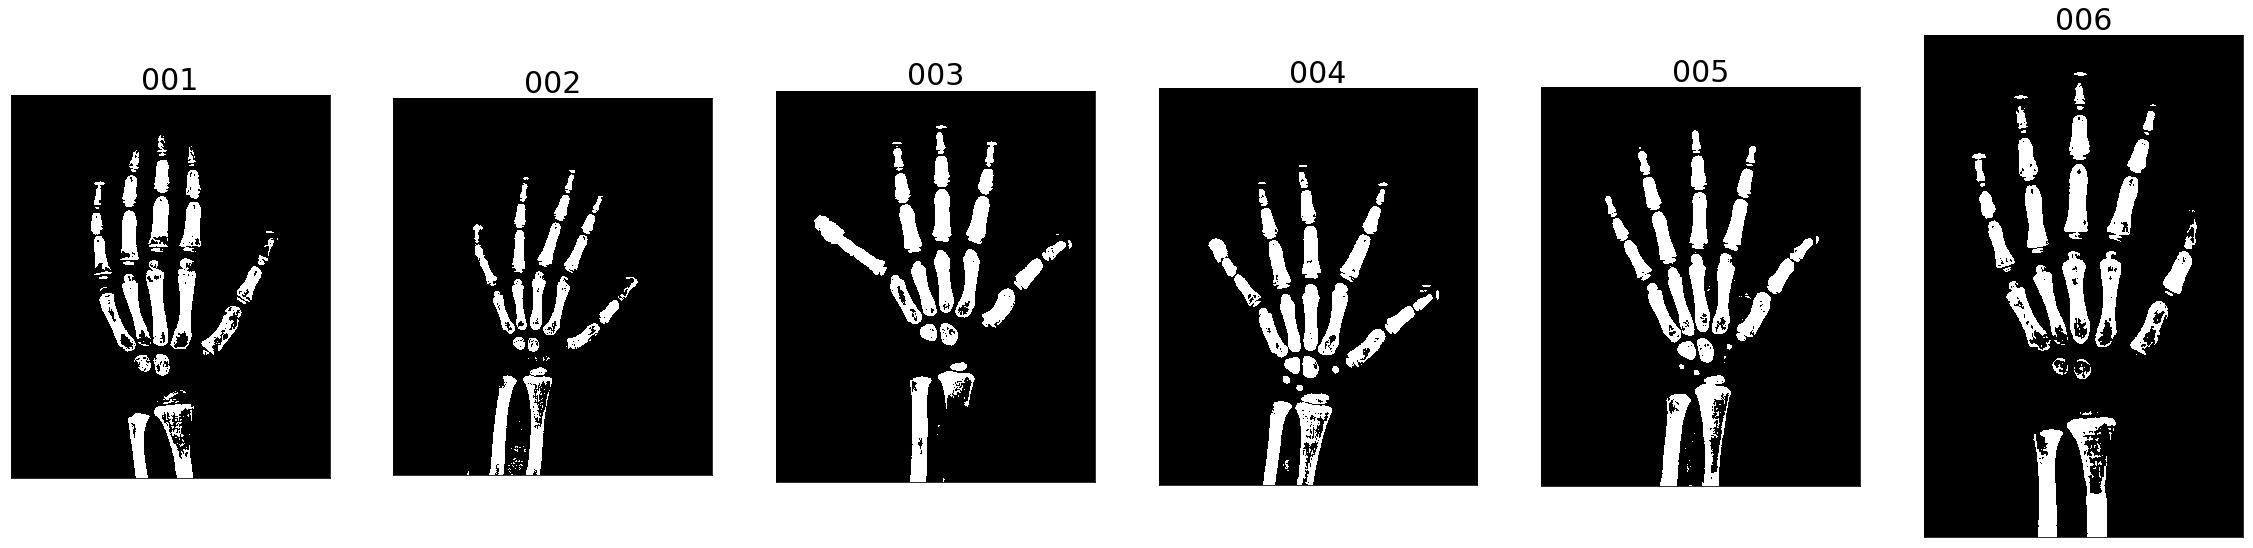

In [41]:
plt.figure(figsize=(40, 20))
for i in range(6):
    img_path = "./03/{0:03d}_03.jpg".format(i+1)
    img = cv2.imread(img_path)
    plt.subplot(1, 6, i+1)
    plt.title("{0:03d}".format(i+1), {"fontsize":30})
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap = "gray")
plt.show()